In [45]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import sys
import json
import torch
import re
import h5py
import lightning.pytorch as pl
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
warnings.filterwarnings('ignore')
np.random.seed(42)

In [46]:
from helper_fn_short_val import *


In [47]:
dataset_class_summary(r'truncated_labels/truncated_train_pos.npz')


Zn(2+)                   |3399
Mg(2+)                   |1350
[4Fe-4S] cluster         |537
Ca(2+)                   |2758
Mn(2+)                   |679
a divalent metal cation  |8648
Fe cation                |686
[2Fe-2S] cluster         |227
Cu cation                |415
K(+)                     |97
Ni(2+)                   |47
Na(+)                    |79
Fe(3+)                   |82
iron-sulfur cluster      |791
Cu(2+)                   |16
Fe(2+)                   |15
Co(2+)                   |32
a metal cation           |9850
neg                      |1056314


In [48]:
# def retrieve_json(path):
#   with open(path, 'r') as fp:
#     data = json.load(fp)
#   return data


## Read embedding files

In [49]:
f_pos = h5py.File(r'truncated_embeds\train_pos_embeddings.h5', 'r')
f_neg0 = h5py.File(r'truncated_embeds\train_neg0_embeddings.h5', 'r')
f_neg1 = h5py.File(r'truncated_embeds\train_neg1_embeddings.h5', 'r')
f_neg2 = h5py.File(r'truncated_embeds\train_neg2_embeddings.h5', 'r')
f_neg3 = h5py.File(r'truncated_embeds\train_neg3_embeddings.h5', 'r')
f_neg4 = h5py.File(r'truncated_embeds\train_neg4_embeddings.h5', 'r')
f_neg5 = h5py.File(r'truncated_embeds\train_neg5_embeddings.h5', 'r')
f_neg6 = h5py.File(r'truncated_embeds\train_neg6_embeddings.h5', 'r')
f_neg7 = h5py.File(r'truncated_embeds\train_neg7_embeddings.h5', 'r')
f_neg8 = h5py.File(r'truncated_embeds\train_neg8_embeddings.h5', 'r')
f_neg9 = h5py.File(r'truncated_embeds\train_neg9_embeddings.h5', 'r')
f_neg10 = h5py.File(r'truncated_embeds\train_neg10_embeddings.h5', 'r')
f_neg11 = h5py.File(r'truncated_embeds\train_neg11_embeddings.h5', 'r')
f_neg12 = h5py.File(r'truncated_embeds\train_neg12_embeddings.h5', 'r')
f_neg13 = h5py.File(r'truncated_embeds\train_neg13_embeddings.h5', 'r')
f_neg14 = h5py.File(r'truncated_embeds\train_neg14_embeddings.h5', 'r')
f_neg15 = h5py.File(r'truncated_embeds\train_neg15_embeddings.h5', 'r')


In [50]:
f_test = h5py.File(r'truncated_embeds\test_embeddings.h5', 'r')

## Train Validation Split

In [51]:
five_fold_splits1 = five_fold_val_split(
    r'truncated_labels/truncated_train_pos.npz')
five_fold_splits2 = five_fold_val_split(
    r'truncated_labels/truncated_train_neg0.npz')
five_fold_splits3 = five_fold_val_split(
    r'truncated_labels/truncated_train_neg1.npz')
five_fold_splits4 = five_fold_val_split(
    r'truncated_labels/truncated_train_neg2.npz')
five_fold_splits5 = five_fold_val_split(
    r'truncated_labels/truncated_train_neg3.npz')
five_fold_splits6 = five_fold_val_split(
    r'truncated_labels/truncated_train_neg4.npz')
five_fold_splits7 = five_fold_val_split(
    r'truncated_labels/truncated_train_neg5.npz')
five_fold_splits8 = five_fold_val_split(
    r'truncated_labels/truncated_train_neg6.npz')
five_fold_splits9 = five_fold_val_split(
    r'truncated_labels/truncated_train_neg7.npz')
five_fold_splits10 = five_fold_val_split(
    r'truncated_labels/truncated_train_neg8.npz')
five_fold_splits11 = five_fold_val_split(
    r'truncated_labels/truncated_train_neg9.npz')
five_fold_splits12 = five_fold_val_split(
    r'truncated_labels/truncated_train_neg10.npz')
five_fold_splits13 = five_fold_val_split(
    r'truncated_labels/truncated_train_neg11.npz')
five_fold_splits14 = five_fold_val_split(
    r'truncated_labels/truncated_train_neg12.npz')
five_fold_splits15 = five_fold_val_split(
    r'truncated_labels/truncated_train_neg13.npz')
five_fold_splits16 = five_fold_val_split(
    r'truncated_labels/truncated_train_neg14.npz')
five_fold_splits17 = five_fold_val_split(
    r'truncated_labels/truncated_train_neg15.npz')


not enough data to divide ['CHEBI:29033', 'Fe(2+)'], add to all split!


In [52]:
for i in range(5):
    print(f"fold {i+1}")
    print(
        f"{'pos':25}|{len(five_fold_splits1[f'fold{i}']['train'])} {len(five_fold_splits1[f'fold{i}']['test'])}")
    print(
        f"{'neg0':25}|{len(five_fold_splits2[f'fold{i}']['train'])} {len(five_fold_splits2[f'fold{i}']['test'])}")
    print(
        f"{'neg1':25}|{len(five_fold_splits3[f'fold{i}']['train'])} {len(five_fold_splits3[f'fold{i}']['test'])}")
    print(
        f"{'neg2':25}|{len(five_fold_splits4[f'fold{i}']['train'])} {len(five_fold_splits4[f'fold{i}']['test'])}")
    print(
        f"{'neg3':25}|{len(five_fold_splits5[f'fold{i}']['train'])} {len(five_fold_splits5[f'fold{i}']['test'])}")
    print(
        f"{'neg4':25}|{len(five_fold_splits6[f'fold{i}']['train'])} {len(five_fold_splits6[f'fold{i}']['test'])}")
    print(
        f"{'neg5':25}|{len(five_fold_splits7[f'fold{i}']['train'])} {len(five_fold_splits7[f'fold{i}']['test'])}")
    print(
        f"{'neg6':25}|{len(five_fold_splits8[f'fold{i}']['train'])} {len(five_fold_splits8[f'fold{i}']['test'])}")
    print(
        f"{'neg7':25}|{len(five_fold_splits9[f'fold{i}']['train'])} {len(five_fold_splits9[f'fold{i}']['test'])}")
    print(
        f"{'neg8':25}|{len(five_fold_splits10[f'fold{i}']['train'])} {len(five_fold_splits10[f'fold{i}']['test'])}")
    print(
        f"{'neg9':25}|{len(five_fold_splits11[f'fold{i}']['train'])} {len(five_fold_splits11[f'fold{i}']['test'])}")
    print(
        f"{'neg10':25}|{len(five_fold_splits12[f'fold{i}']['train'])} {len(five_fold_splits12[f'fold{i}']['test'])}")
    print(
        f"{'neg11':25}|{len(five_fold_splits13[f'fold{i}']['train'])} {len(five_fold_splits13[f'fold{i}']['test'])}")
    print(
        f"{'neg12':25}|{len(five_fold_splits14[f'fold{i}']['train'])} {len(five_fold_splits14[f'fold{i}']['test'])}")
    print(
        f"{'neg13':25}|{len(five_fold_splits15[f'fold{i}']['train'])} {len(five_fold_splits15[f'fold{i}']['test'])}")
    print(
        f"{'neg14':25}|{len(five_fold_splits16[f'fold{i}']['train'])} {len(five_fold_splits16[f'fold{i}']['test'])}")
    print(
        f"{'neg15':25}|{len(five_fold_splits17[f'fold{i}']['train'])} {len(five_fold_splits17[f'fold{i}']['test'])}")

    print()


fold 1
pos                      |2464 625
neg0                     |2475 619
neg1                     |2507 627
neg2                     |2533 634
neg3                     |2412 603
neg4                     |2451 613
neg5                     |2550 638
neg6                     |2388 598
neg7                     |2492 623
neg8                     |2436 609
neg9                     |2440 611
neg10                    |2493 624
neg11                    |2504 627
neg12                    |2467 617
neg13                    |2474 619
neg14                    |2487 622
neg15                    |2442 611

fold 2
pos                      |2467 622
neg0                     |2475 619
neg1                     |2507 627
neg2                     |2533 634
neg3                     |2412 603
neg4                     |2451 613
neg5                     |2550 638
neg6                     |2389 597
neg7                     |2492 623
neg8                     |2436 609
neg9                     |2441 610
neg10

## Acc ls generate

In [53]:

train_pos = five_fold_splits1['fold0']['train'].copy()
train_neg = [five_fold_splits2['fold0']['train'].copy(), five_fold_splits3['fold0']['train'].copy(), five_fold_splits4['fold0']['train'].copy(), five_fold_splits5['fold0']['train'].copy(), five_fold_splits6['fold0']['train'].copy(), five_fold_splits7['fold0']['train'].copy(), five_fold_splits8['fold0']['train'].copy(), five_fold_splits9['fold0']['train'].copy(
), five_fold_splits10['fold0']['train'].copy(), five_fold_splits11['fold0']['train'].copy(), five_fold_splits12['fold0']['train'].copy(), five_fold_splits13['fold0']['train'].copy(), five_fold_splits14['fold0']['train'].copy(), five_fold_splits15['fold0']['train'].copy(), five_fold_splits16['fold0']['train'].copy(), five_fold_splits17['fold0']['train'].copy()]


In [54]:
valid_acc = five_fold_splits1['fold0']['test'].copy()
valid_acc.extend(five_fold_splits2['fold0']['test'])
valid_acc.extend(five_fold_splits3['fold0']['test'])
valid_acc.extend(five_fold_splits4['fold0']['test'])
valid_acc.extend(five_fold_splits5['fold0']['test'])
valid_acc.extend(five_fold_splits6['fold0']['test'])
valid_acc.extend(five_fold_splits7['fold0']['test'])
valid_acc.extend(five_fold_splits8['fold0']['test'])
valid_acc.extend(five_fold_splits9['fold0']['test'])
valid_acc.extend(five_fold_splits10['fold0']['test'])
valid_acc.extend(five_fold_splits11['fold0']['test'])
valid_acc.extend(five_fold_splits12['fold0']['test'])
valid_acc.extend(five_fold_splits13['fold0']['test'])
valid_acc.extend(five_fold_splits14['fold0']['test'])
valid_acc.extend(five_fold_splits15['fold0']['test'])
valid_acc.extend(five_fold_splits16['fold0']['test'])
valid_acc.extend(five_fold_splits17['fold0']['test'])
len(valid_acc)


10520

In [55]:
test_acc_ls = list(f_test.keys())


## Read labels files

In [56]:
l1 = np.load(r'truncated_labels/truncated_train_pos.npz')
l2 = np.load(r'truncated_labels/truncated_train_neg0.npz')
l3 = np.load(r'truncated_labels/truncated_train_neg1.npz')
l4 = np.load(r'truncated_labels/truncated_train_neg2.npz')
l5 = np.load(r'truncated_labels/truncated_train_neg3.npz')
l6 = np.load(r'truncated_labels/truncated_train_neg4.npz')
l7 = np.load(r'truncated_labels/truncated_train_neg5.npz')
l8 = np.load(r'truncated_labels/truncated_train_neg6.npz')
l9 = np.load(r'truncated_labels/truncated_train_neg7.npz')
l10 = np.load(r'truncated_labels/truncated_train_neg8.npz')
l11 = np.load(r'truncated_labels/truncated_train_neg9.npz')
l12 = np.load(r'truncated_labels/truncated_train_neg10.npz')
l13 = np.load(r'truncated_labels/truncated_train_neg11.npz')
l14 = np.load(r'truncated_labels/truncated_train_neg12.npz')
l15 = np.load(r'truncated_labels/truncated_train_neg13.npz')
l16 = np.load(r'truncated_labels/truncated_train_neg14.npz')
l17 = np.load(r'truncated_labels/truncated_train_neg15.npz')


In [57]:
l1 = {key: value for key, value in l1.items()}
l2 = {key: value for key, value in l2.items()}
l3 = {key: value for key, value in l3.items()}
l4 = {key: value for key, value in l4.items()}
l5 = {key: value for key, value in l5.items()}
l6 = {key: value for key, value in l6.items()}
l7 = {key: value for key, value in l7.items()}
l8 = {key: value for key, value in l8.items()}
l9 = {key: value for key, value in l9.items()}
l10 = {key: value for key, value in l10.items()}
l11 = {key: value for key, value in l11.items()}
l12 = {key: value for key, value in l12.items()}
l13 = {key: value for key, value in l13.items()}
l14 = {key: value for key, value in l14.items()}
l15 = {key: value for key, value in l15.items()}
l16 = {key: value for key, value in l16.items()}
l17 = {key: value for key, value in l17.items()}


In [58]:
label = l1 | l2 | l3 | l4 | l5 | l6 | l7 | l8 | l9 | l10 | l11 | l12 | l13 | l14 | l15 | l16 | l17
len(label)


52533

In [59]:
label_valid = {key: value for key, value in (
    label).items() if key in valid_acc}
len(label_valid)


10520

In [60]:
label_test = np.load(r'truncated_labels/truncated_test.npz')
label_test = {key: value for key, value in label_test.items()}


In [61]:
len(label_test)

5822

todo:
1. dataset里读file
2. 用Subset分成train和val
3. lightining传多个dataloaders

In [62]:

class MyStreamDataset_over_sample:

    def __init__(self, pos_acc, neg_acc_ls, labels, pos, neg=None, max_len=512, precision=np.float16):
        self.pos_f = pos  # h5 file
        self.labels = labels  # labels for both pos and neg
        self.index = np.random.randint(0, len(neg_acc_ls))
        print(f"neg index: {self.index}")
        self.neg_f = neg[self.index]
        self.acc_ls = pos_acc + neg_acc_ls[self.index]
        self.pos_acc = list(self.pos_f.keys())
        self.labels = labels  # labels for both pos and neg
        self.dim = self.pos_f[list(self.pos_f.keys())[0]][()].shape[1]
        self.max_len = max_len
        self.precision = precision

    def __len__(self):
        return len(self.acc_ls)

    def __getitem__(self, idx):
        acc = self.acc_ls[idx]
        if acc in self.pos_acc:
            embedding = self.pos_f[acc][()]
        else:
            embedding = self.neg_f[acc][()]

        label = self.labels[acc]

        prot_len = embedding.shape[0]

        if label.shape == (1,):
            label = np.zeros((18, prot_len), dtype=self.precision)

        if self.precision == np.float16:
            torch_type = torch.float16
        else:
            torch_type = torch.float32

        features = np.zeros((self.dim, self.max_len), dtype=self.precision)
        # set feature maps to embedding values
        features[:, :prot_len] = np.transpose(embedding)
        mask = np.zeros((self.max_len), dtype=bool)
        mask[:prot_len] = True

        return torch.tensor(features, dtype=torch_type), torch.tensor(label, dtype=torch_type), torch.tensor(mask, dtype=torch.bool)

    def collate_fn(self, batch):
        features, labels, masks = zip(*batch)
        return torch.stack(features), torch.hstack(labels), torch.hstack(masks)


In [63]:
class MyStreamDataset:
    def __init__(self, acc_ls, labels, files, max_len=512, precision=np.float16):
        self.files = files  # h5 file
        self.acc_ls = acc_ls
        self.labels = labels  # labels for both pos and neg
        f0 = self.files[0]
        self.dim = f0[list(f0.keys())[0]][()].shape[1]
        self.max_len = max_len
        self.precision = precision

    def __len__(self):
        return len(self.acc_ls)

    def __getitem__(self, idx):
        acc = self.acc_ls[idx]
        for f in self.files:
            f_acc = list(f.keys())
            if acc in f_acc:
                embedding = f[acc][()]
                break
        label = self.labels[acc]

        prot_len = embedding.shape[0]

        if label.shape == (1,):
            label = np.zeros((18, prot_len), dtype=self.precision)

        # pad all inputs to the maximum length & add another feature to encode whether the element is a position
        # in the sequence or padded
        features = np.zeros((self.dim, self.max_len), dtype=self.precision)
        # set feature maps to embedding values
        features[:, :prot_len] = np.transpose(embedding)
        mask = np.zeros((self.max_len), dtype=bool)
        mask[:prot_len] = True
        if self.precision == np.float16:
            torch_type = torch.float16
        else:
            torch_type = torch.float32
        return torch.tensor(features, dtype=torch_type), torch.tensor(label, dtype=torch_type), torch.tensor(mask, dtype=torch.bool)

    def collate_fn(self, batch):
        features, labels, masks = zip(*batch)
        return torch.stack(features), torch.hstack(labels), torch.hstack(masks)


In [64]:
# train_dataset1 = MySteamDataset(train_1, label1, f_pos, f_neg0, max_len=512, precision=np.float32)
# train_dataloader1 = torch.utils.data.DataLoader(train_dataset1, batch_size=4, shuffle=True, collate_fn=train_dataset1.collate_fn, drop_last=True)


In [65]:
val_dataset = MyStreamDataset(valid_acc, label_valid, [f_pos, f_neg0, f_neg1, f_neg2, f_neg3, f_neg4, f_neg5,
                              f_neg6, f_neg7, f_neg8, f_neg9, f_neg10, f_neg11, f_neg12, f_neg13, f_neg14, f_neg15], precision=np.float32)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=val_dataset.collate_fn, drop_last=True)

In [66]:
test_dataset = MyStreamDataset(test_acc_ls, label_test, [f_test], precision=np.float32)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=16, shuffle=False, collate_fn=test_dataset.collate_fn, drop_last=True)


In [67]:
# for features, labels, mask in train_dataloader1:
#     print(features.shape)
#     print(labels[0].shape)
#     print(mask[0].shape)
#     break

In [68]:
for features, labels, mask in val_dataloader:
    print(features.shape)
    print(labels.shape)
    print(mask.shape)
    break


torch.Size([16, 1536, 512])
torch.Size([18, 5326])
torch.Size([8192])


In [69]:

for features, labels, mask in test_dataloader:
    print(features.shape)
    print(labels.shape)
    print(mask.shape)
    break

torch.Size([16, 1536, 512])
torch.Size([18, 5638])
torch.Size([8192])


In [70]:
class Conv1dModel(pl.LightningModule):
    def __init__(self, train_pos, train_neg, in_channels, feature_channels, kernel_size, dropout, hidden_layer_num, lr=1e-3, label_weight=[0.228, 5.802], batch_size=32):
        super().__init__()
        stride = 1
        padding = int((kernel_size - 1) / 2)
        modules = []
        in_channel_ = in_channels
        feature_channel_ = feature_channels
        for i in range(hidden_layer_num):
          modules.append(torch.nn.Conv1d(in_channels=in_channel_, out_channels=feature_channel_, kernel_size=kernel_size,
                                         stride=stride, padding=padding))
          modules.append(torch.nn.ELU())
          in_channel_ = feature_channel_
          feature_channel_ = feature_channel_//2

        modules.append(torch.nn.Conv1d(in_channels=in_channel_, out_channels=18,
                                       kernel_size=kernel_size, stride=stride, padding=padding))

        self.conv1 = torch.nn.Sequential(*modules)

        self.save_hyperparameters()

        self.val_loss = 0
        self.test_loss = 0
        self.learning_rate = lr
        self.label_weight = label_weight
        self.batch_size = batch_size
        self.train_pos = train_pos
        self.train_neg = train_neg
        self.val_y = []
        self.val_pred = []
        self.test_y = []
        self.test_pred = []

    def forward(self, x):
        x = self.conv1(x)
        return torch.squeeze(x)

    def loss_fn(self, out, target):
        weight = torch.ones_like(target)
        # 0.228, 5.802
        weight[target == 0] = self.label_weight[0]
        weight[target == 1] = self.label_weight[1]
        return torch.nn.BCEWithLogitsLoss(reduction='none', weight=weight)(out, target).mean(axis=0).sum()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=64)
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        x, y, masks = batch
        out = self(x)
        out = torch.hstack([i for i in out])[:, masks].T
        loss = self.loss_fn(out, y.T)
        self.log('train_loss', loss)
        return loss

    def train_dataloader(self):
        train_dataset = MyStreamDataset_over_sample(self.train_pos, self.train_neg, label, f_pos, [
                                                    f_neg0, f_neg1, f_neg2, f_neg3, f_neg4, f_neg5, f_neg6, f_neg7, f_neg8, f_neg9, f_neg10, f_neg11, f_neg12, f_neg13, f_neg14, f_neg15], precision=np.float32)

        train_dataloader = torch.utils.data.DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)
        return train_dataloader

    def validation_step(self, batch, batch_idx):
        x, y, masks = batch
        out = self(x)
        # print(out.shape)
        out = torch.hstack([i for i in out])[:, masks]
        loss = self.loss_fn(out.T, y.T)
        self.val_loss += loss
        self.val_y.append(y)
        self.val_pred.append(out)

    def on_validation_epoch_start(self):
        #print('Validation start')
        self.val_loss = 0
        self.val_y = []
        self.val_pred = []

    def on_validation_epoch_end(self):
        y = torch.hstack(self.val_y)
        out = torch.hstack(self.val_pred)
        out = torch.sigmoid(out)
        y_true = y.detach().cpu().numpy()
        y_pred = out.detach().cpu().numpy()
        dc = sum_metrics(y_true, y_pred, 0.5)
        self.val_loss = self.val_loss / len(self.val_y)
        loss = self.val_loss
        print(f'Validation loss: {loss}')
        self.log('val_loss', loss)
        self.log('MCC', dc['mean MCC'])
        self.log('AUPR', dc['mean AUPR'])

    def test_step(self, batch, batch_idx):
        x, y, masks = batch
        out = self(x)
        out = torch.hstack([i for i in out])[:, masks]
        loss = self.loss_fn(out.T, y.T)
        self.test_loss += loss
        self.test_y.append(y)
        self.test_pred.append(out)

    def on_test_epoch_end(self):
        y = torch.hstack(self.test_y)
        out = torch.hstack(self.test_pred)
        out = torch.sigmoid(out)
        y_true = y.detach().cpu().numpy()
        y_pred = out.detach().cpu().numpy()
        #dc = sum_metrics1(y_true, y_pred, 0.5)
        dc = sum_metrics1(y_true, y_pred, [0.99, 0.59, 0.52, 0.80, 0.76, 0.96, 0.38, 0.74, 0.26, 0.58, 0.30, 0.96, 0.10, 0.97, 0.36, 0.11, 0.18, 0.85])
        plot_pr_curve(y_true, y_pred)
        self.test_loss = self.test_loss / len(self.test_y)
        self.log('test_loss', self.test_loss)


In [71]:

in_channel = f_pos[list(f_pos.keys())[0]][()].shape[1]
feature_channel = 128
hidden_layer_num = 2
kernel_size = 17
stride = 1
padding = int((kernel_size - 1) / 2)
lr = 0.001
label_weight = (0.228, 5.802)
batch_size = 16
model = Conv1dModel(train_pos, train_neg, in_channel, feature_channel, kernel_size,
                    dropout, hidden_layer_num, lr=lr, label_weight=label_weight, batch_size=batch_size)

early_stopping = EarlyStopping(monitor='AUPR', patience=3, mode='max')
checkpoint_callback = ModelCheckpoint(
    filename='{epoch}-{val_loss:.6f}-{MCC:.3f}-{AUPR:.3f}', save_top_k=3, monitor="AUPR", save_last=True, mode='max')
trainer = pl.Trainer(accelerator='gpu', min_epochs=100, max_epochs=1000, precision=32, callbacks=[
                     early_stopping, checkpoint_callback], check_val_every_n_epoch=10, reload_dataloaders_every_n_epochs=1)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model=model, val_dataloaders=val_dataloader)


You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Sequential | 3.5 M 
-------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.006    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


mean                     |MCC(-1-1): -0.001|AUPR(0-1): 0.002
Validation loss: 2.9539194107055664
neg index: 6


Training: 0it [00:00, ?it/s]

neg index: 3
neg index: 12
neg index: 14
neg index: 10
neg index: 7
neg index: 12
neg index: 4
neg index: 6
neg index: 9


Validation: 0it [00:00, ?it/s]


mean                     |MCC(-1-1):  0.329|AUPR(0-1): 0.312
Validation loss: 0.02369287982583046
neg index: 2
neg index: 6
neg index: 10
neg index: 10
neg index: 7
neg index: 4
neg index: 3
neg index: 7
neg index: 7
neg index: 2


Validation: 0it [00:00, ?it/s]


mean                     |MCC(-1-1):  0.409|AUPR(0-1): 0.350
Validation loss: 0.03877411037683487
neg index: 5
neg index: 4
neg index: 1
neg index: 7
neg index: 11
neg index: 13
neg index: 5
neg index: 1
neg index: 15
neg index: 11


Validation: 0it [00:00, ?it/s]


mean                     |MCC(-1-1):  0.441|AUPR(0-1): 0.364
Validation loss: 0.045927923172712326
neg index: 4
neg index: 0
neg index: 11
neg index: 9
neg index: 5
neg index: 12
neg index: 11
neg index: 8
neg index: 0
neg index: 10


Validation: 0it [00:00, ?it/s]


mean                     |MCC(-1-1):  0.460|AUPR(0-1): 0.409
Validation loss: 0.05454603582620621
neg index: 10
neg index: 14
neg index: 9
neg index: 15
neg index: 11
neg index: 11
neg index: 15
neg index: 14
neg index: 13
neg index: 13


Validation: 0it [00:00, ?it/s]


mean                     |MCC(-1-1):  0.467|AUPR(0-1): 0.399
Validation loss: 0.05919095128774643
neg index: 14
neg index: 13
neg index: 2
neg index: 11
neg index: 6
neg index: 3
neg index: 15
neg index: 8
neg index: 2
neg index: 4


Validation: 0it [00:00, ?it/s]


mean                     |MCC(-1-1):  0.468|AUPR(0-1): 0.416
Validation loss: 0.06600072234869003
neg index: 2
neg index: 6
neg index: 4
neg index: 8
neg index: 6
neg index: 1
neg index: 3
neg index: 8
neg index: 11
neg index: 13


Validation: 0it [00:00, ?it/s]


mean                     |MCC(-1-1):  0.469|AUPR(0-1): 0.415
Validation loss: 0.06596088409423828
neg index: 1
neg index: 9
neg index: 8
neg index: 9
neg index: 4
neg index: 1
neg index: 3
neg index: 11
neg index: 14
neg index: 11


Validation: 0it [00:00, ?it/s]


mean                     |MCC(-1-1):  0.468|AUPR(0-1): 0.425
Validation loss: 0.06412139534950256
neg index: 6
neg index: 11
neg index: 12
neg index: 7
neg index: 14
neg index: 2
neg index: 13
neg index: 0
neg index: 3
neg index: 1


Validation: 0it [00:00, ?it/s]


mean                     |MCC(-1-1):  0.425|AUPR(0-1): 0.392
Validation loss: 0.05749334767460823
neg index: 7
neg index: 3
neg index: 1
neg index: 13
neg index: 5
neg index: 5
neg index: 9
neg index: 3
neg index: 5
neg index: 12


Validation: 0it [00:00, ?it/s]


mean                     |MCC(-1-1):  0.415|AUPR(0-1): 0.386
Validation loss: 0.05900362879037857
neg index: 14
neg index: 1
neg index: 9
neg index: 11
neg index: 1
neg index: 9
neg index: 13
neg index: 3
neg index: 13
neg index: 14


Validation: 0it [00:00, ?it/s]


mean                     |MCC(-1-1):  0.401|AUPR(0-1): 0.378
Validation loss: 0.05088748782873154


You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at lightning_logs\cnn1\checkpoints\epoch=79-val_loss=0.064121-MCC=0.468-AUPR=0.425.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at lightning_logs\cnn1\checkpoints\epoch=79-val_loss=0.064121-MCC=0.468-AUPR=0.425.ckpt


Testing: 0it [00:00, ?it/s]


Zn(2+)                   |precision:  0.339|recall:  0.540|specificity:  1.000|MCC:  0.428|AUROC: 0.985|AUPR: 0.288
Mg(2+)                   |precision:  0.347|recall:  0.412|specificity:  1.000|MCC:  0.378|AUROC: 0.960|AUPR: 0.301
[4Fe-4S] cluster         |precision:  0.223|recall:  0.667|specificity:  1.000|MCC:  0.386|AUROC: 1.000|AUPR: 0.155
Ca(2+)                   |precision:  0.223|recall:  0.394|specificity:  1.000|MCC:  0.296|AUROC: 0.979|AUPR: 0.135
Mn(2+)                   |precision:  0.050|recall:  0.099|specificity:  1.000|MCC:  0.070|AUROC: 0.956|AUPR: 0.022
a divalent metal cation  |precision:  0.376|recall:  0.509|specificity:  1.000|MCC:  0.437|AUROC: 0.977|AUPR: 0.316
Fe cation                |precision:  0.486|recall:  0.316|specificity:  1.000|MCC:  0.392|AUROC: 0.978|AUPR: 0.202
[2Fe-2S] cluster         |precision:  0.750|recall:  0.828|specificity:  1.000|MCC:  0.788|AUROC: 1.000|AUPR: 0.877
Cu cation                |precision:  0.240|recall:  0.759|specificity:

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.07637038826942444    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.07637038826942444}]

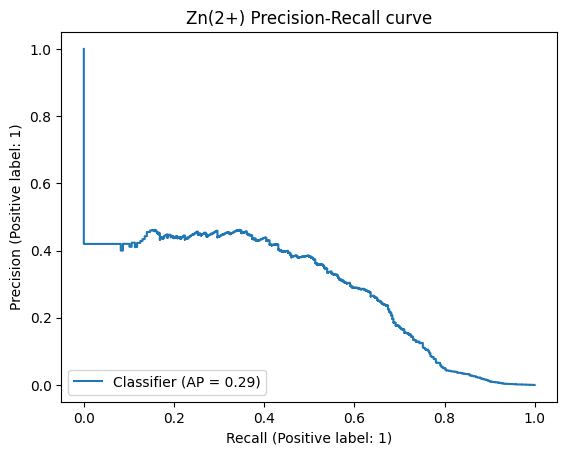

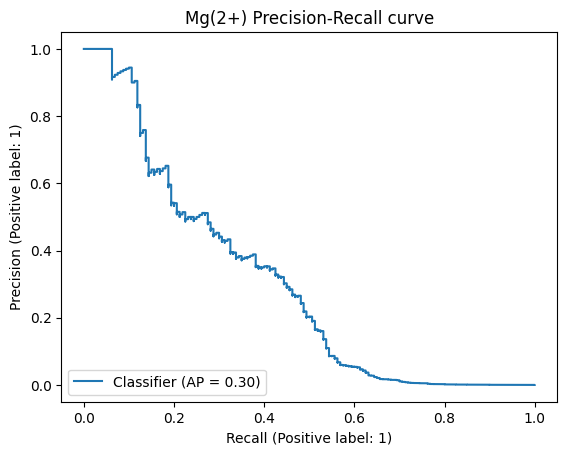

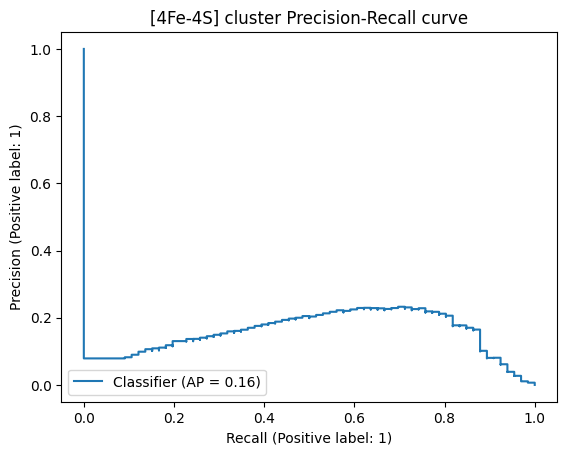

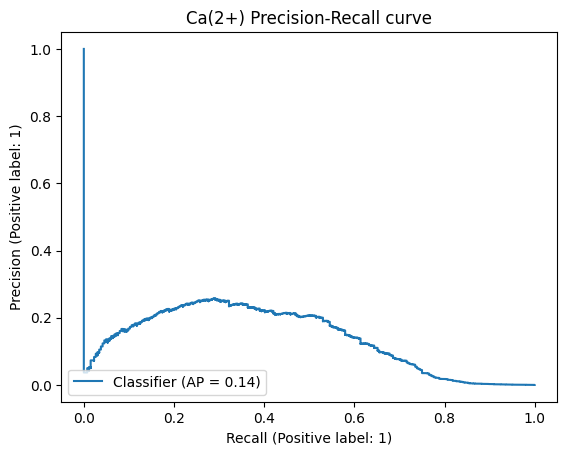

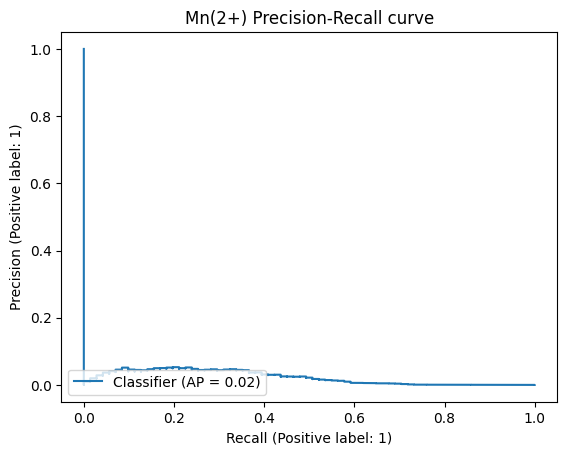

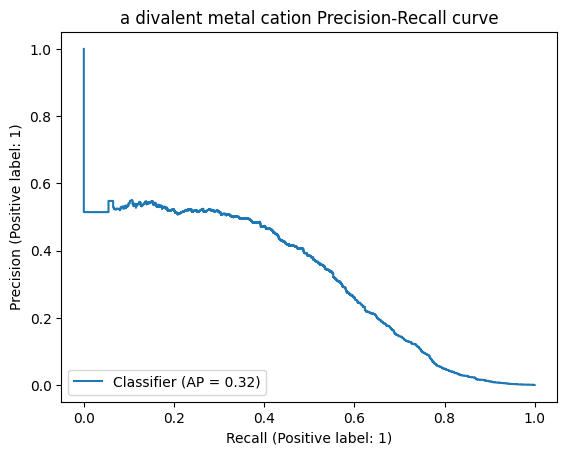

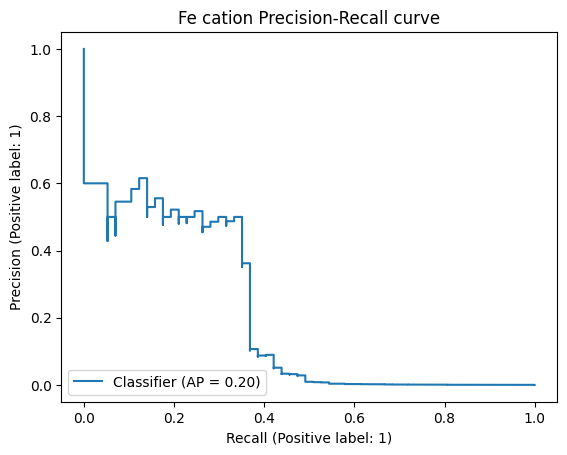

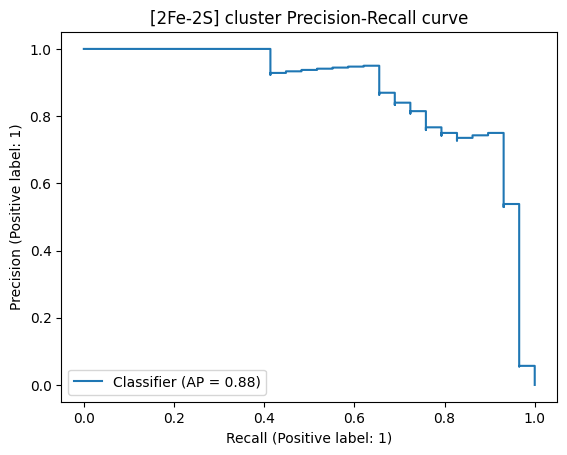

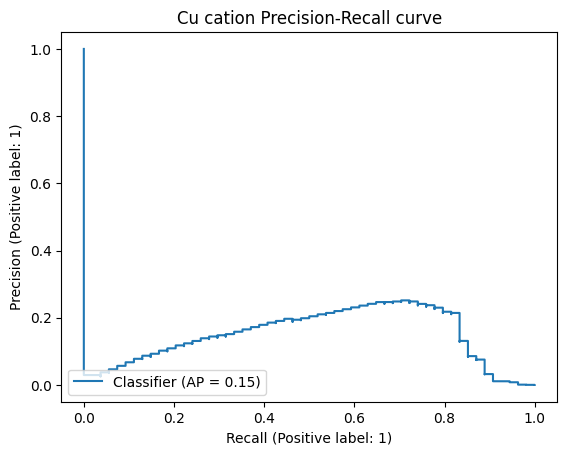

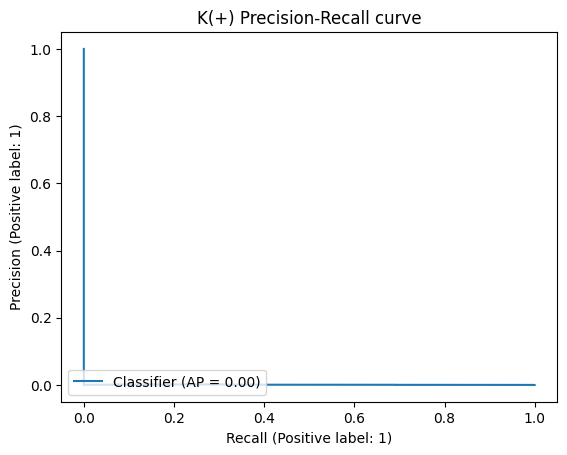

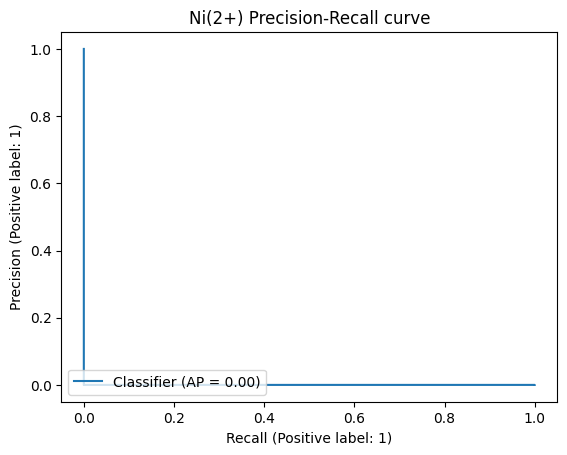

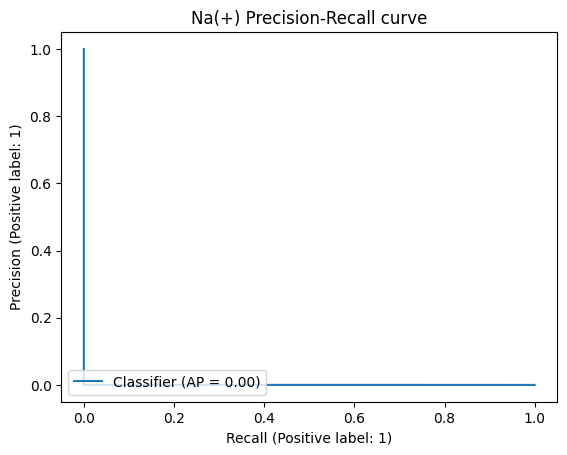

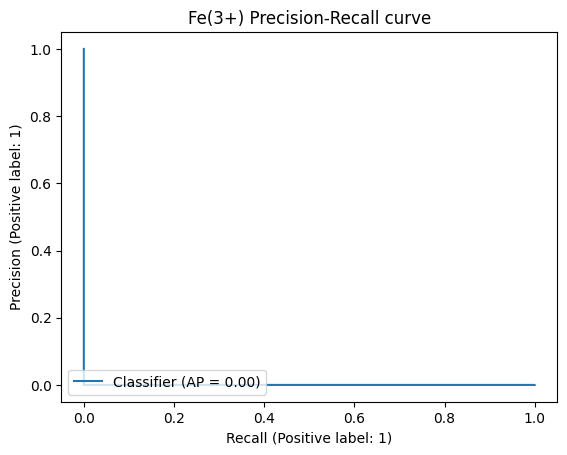

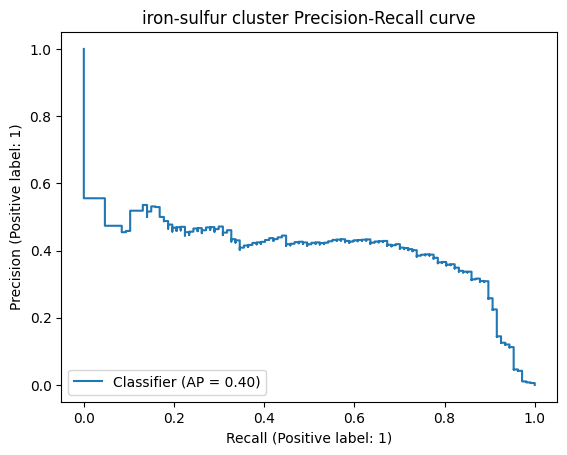

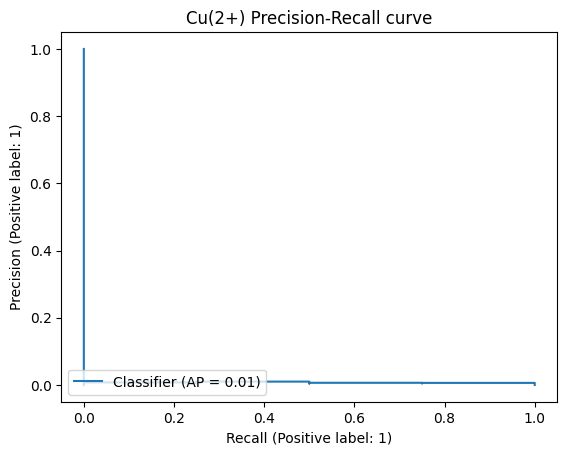

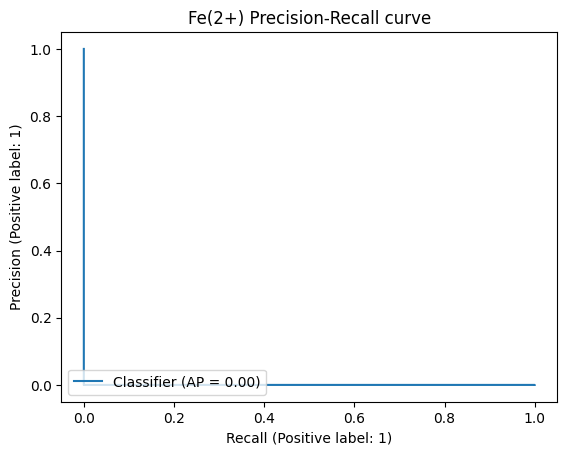

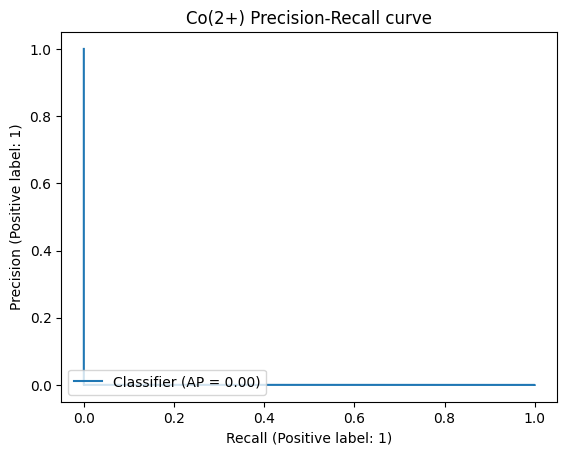

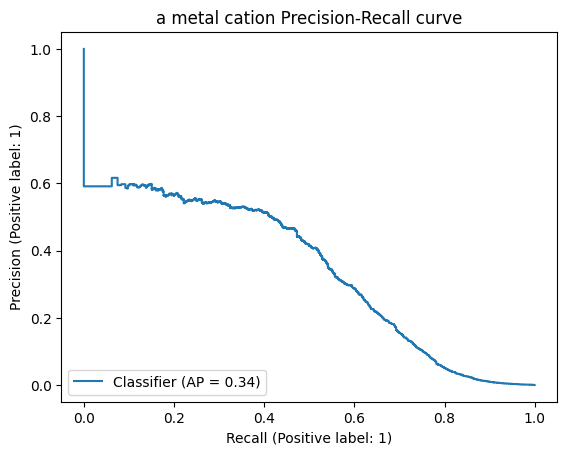

In [44]:
# test (pass in the loader)
trainer.test(model=model, dataloaders=test_dataloader,
             ckpt_path=r'lightning_logs\cnn1\checkpoints\epoch=79-val_loss=0.064121-MCC=0.468-AUPR=0.425.ckpt')


You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at lightning_logs\cnn1\checkpoints\epoch=79-val_loss=0.064121-MCC=0.468-AUPR=0.425.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at lightning_logs\cnn1\checkpoints\epoch=79-val_loss=0.064121-MCC=0.468-AUPR=0.425.ckpt


Testing: 0it [00:00, ?it/s]


Zn(2+)                   |precision:  0.424|recall:  0.412|specificity:  1.000|MCC:  0.418|AUROC: 0.985|AUPR: 0.288
Mg(2+)                   |precision:  0.350|recall:  0.400|specificity:  1.000|MCC:  0.374|AUROC: 0.960|AUPR: 0.301
[4Fe-4S] cluster         |precision:  0.223|recall:  0.667|specificity:  1.000|MCC:  0.386|AUROC: 1.000|AUPR: 0.155
Ca(2+)                   |precision:  0.240|recall:  0.352|specificity:  1.000|MCC:  0.290|AUROC: 0.979|AUPR: 0.135
Mn(2+)                   |precision:  0.034|recall:  0.056|specificity:  1.000|MCC:  0.044|AUROC: 0.956|AUPR: 0.022
a divalent metal cation  |precision:  0.463|recall:  0.415|specificity:  1.000|MCC:  0.438|AUROC: 0.977|AUPR: 0.316
Fe cation                |precision:  0.500|recall:  0.351|specificity:  1.000|MCC:  0.419|AUROC: 0.978|AUPR: 0.202
[2Fe-2S] cluster         |precision:  0.786|recall:  0.759|specificity:  1.000|MCC:  0.772|AUROC: 1.000|AUPR: 0.877
Cu cation                |precision:  0.232|recall:  0.778|specificity:

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03829038515686989    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.03829038515686989}]

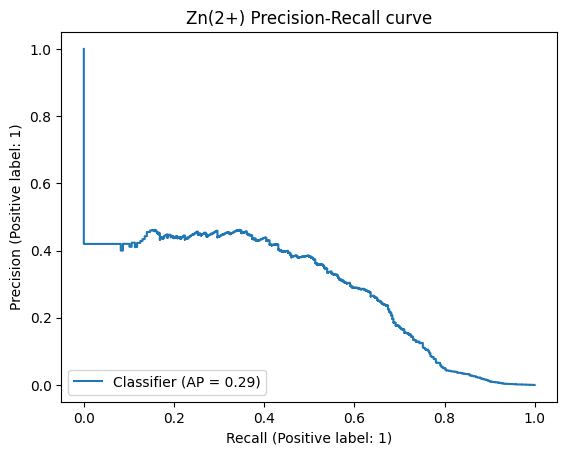

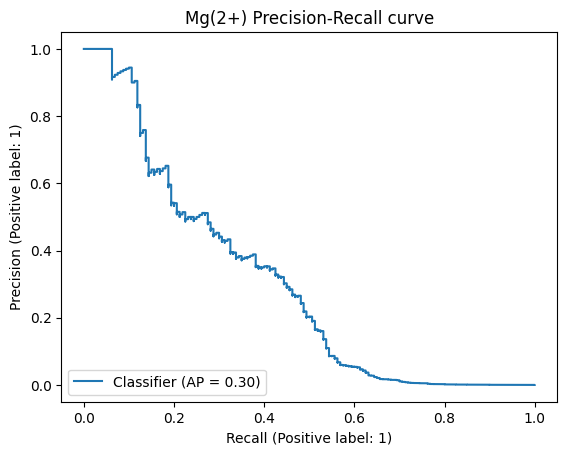

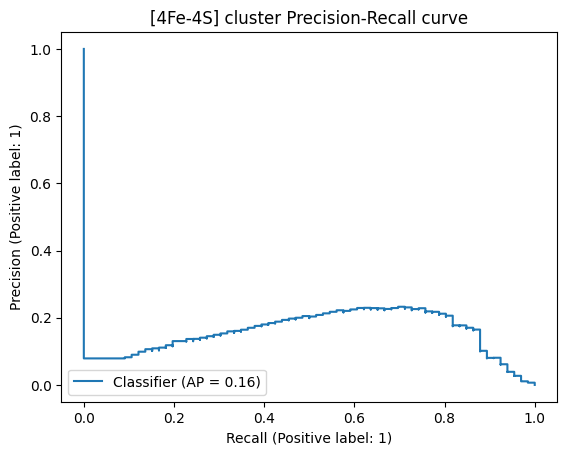

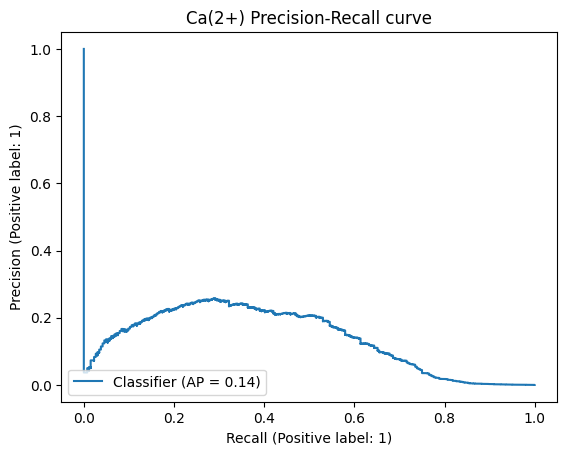

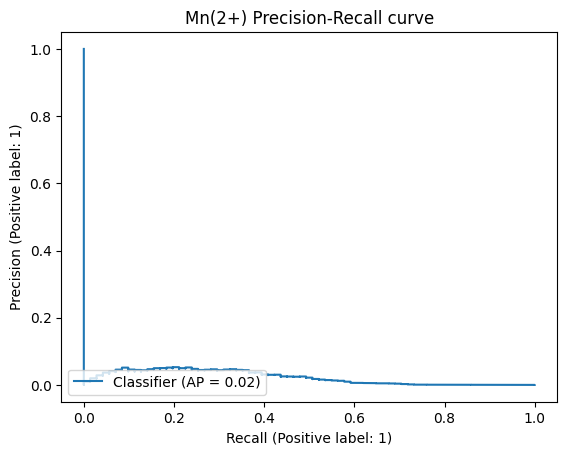

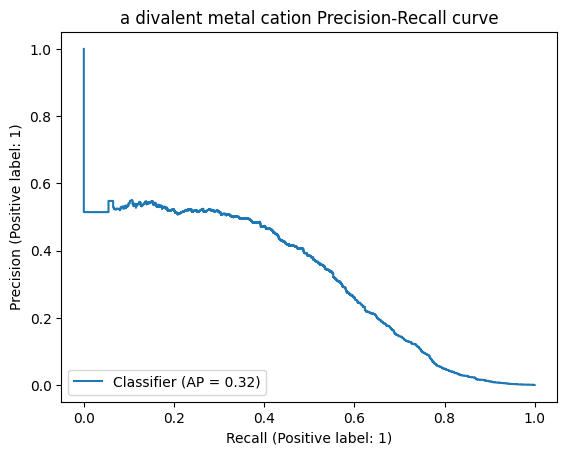

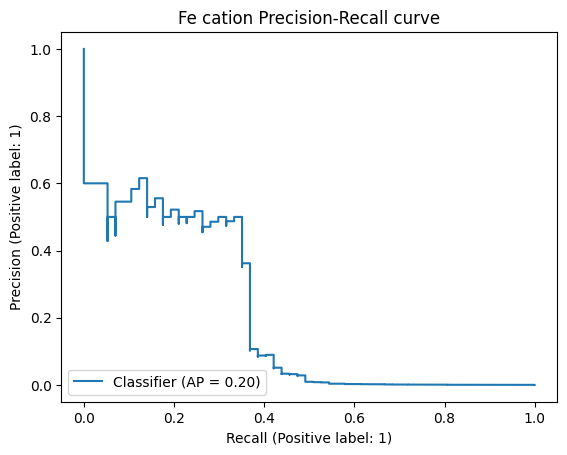

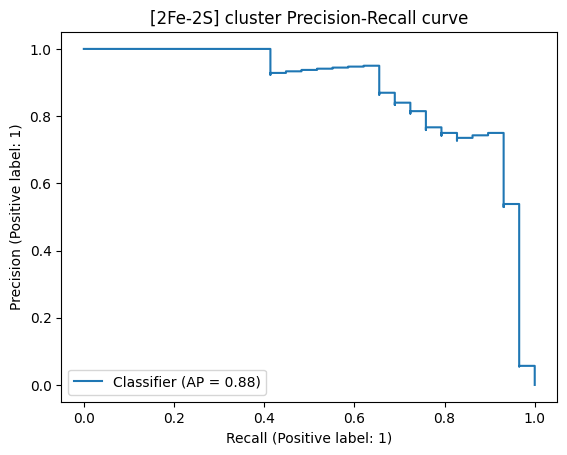

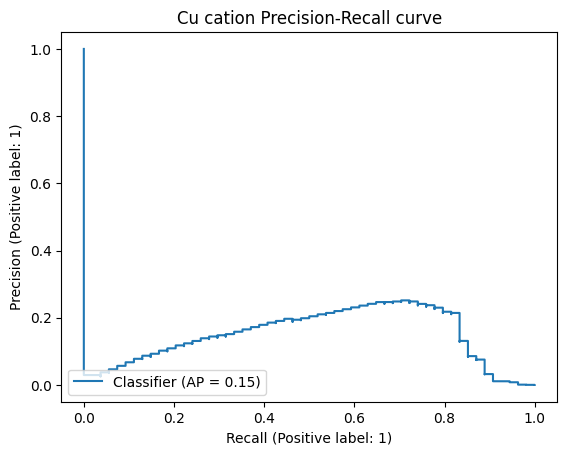

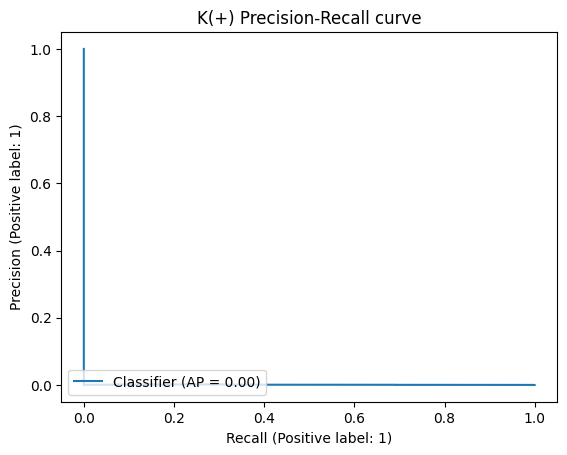

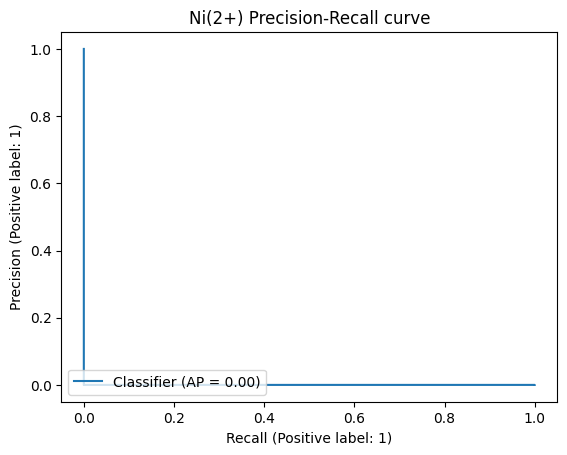

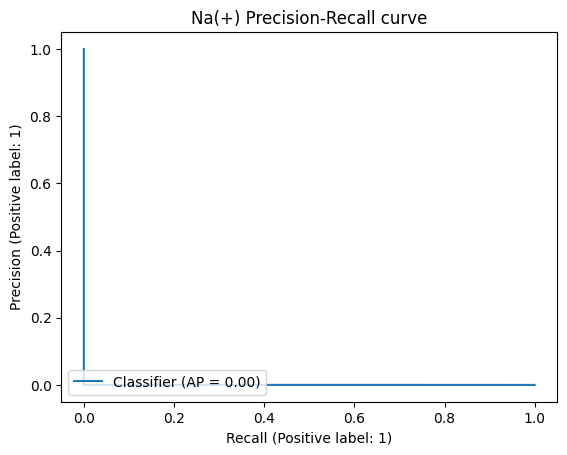

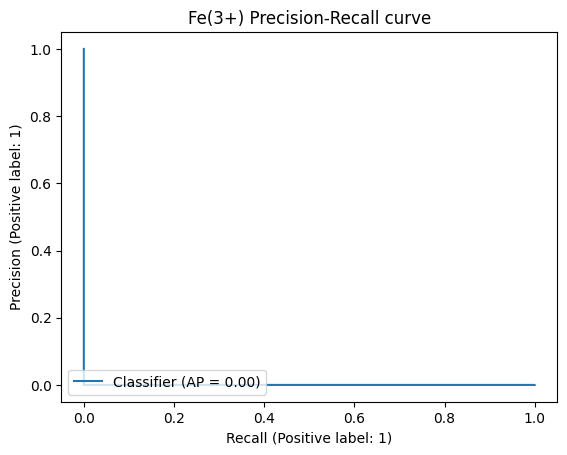

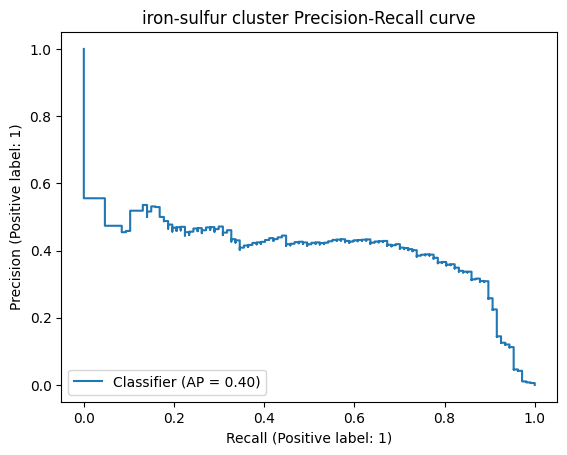

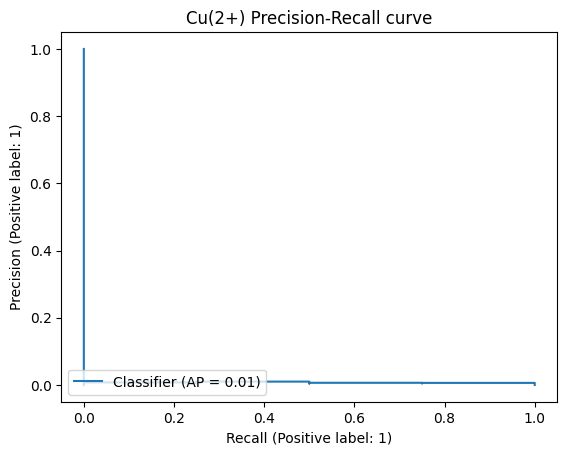

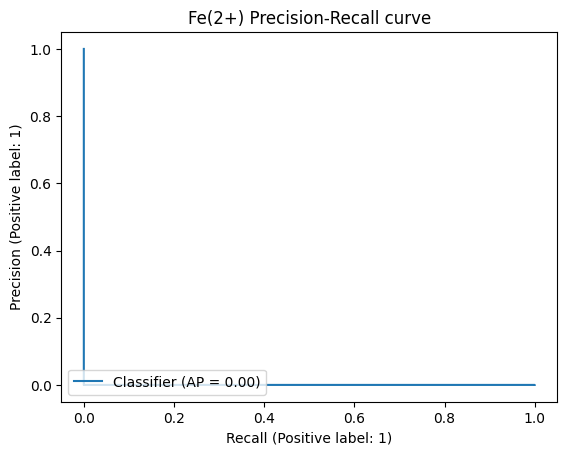

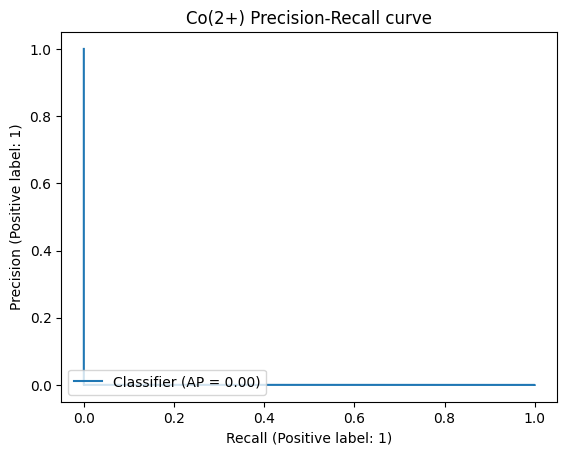

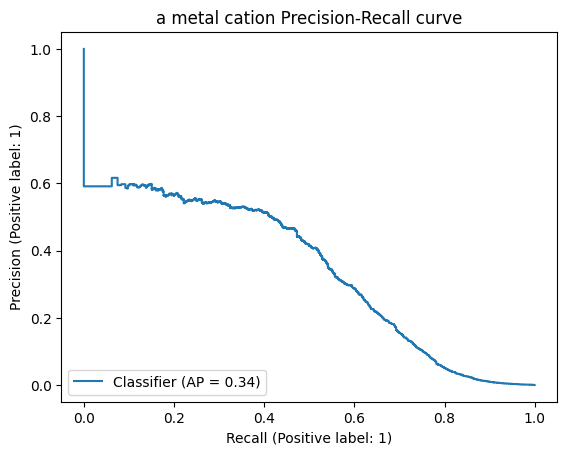

In [73]:
trainer.test(model=model, dataloaders=test_dataloader,
             ckpt_path=r'lightning_logs\cnn1\checkpoints\epoch=79-val_loss=0.064121-MCC=0.468-AUPR=0.425.ckpt')